# Import Library

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import seaborn as sns
import numpy as np 
import xgboost as xgb
import re
import os
import joblib
from math import sqrt
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV

# Visualization Style

In [170]:
formatter = ticker.StrMethodFormatter('Rp.{x:,.0f}')
sns.set_theme(style='darkgrid')
sns.set_palette("deep")
mpl.rcParams['font.family'] = 'sans'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

# Data Collecting

In [171]:
import sys
sys.path.append('..')

from scripts import get_data_from_mongo

In [172]:
df_import = get_data_from_mongo.get_data_mongo('tanah_bali_clean')
df_import = pd.DataFrame(df_import)

----------------------------------------------
Connected to db db_tanah_bali
Total documents get: 23418
Dissconnected!


In [173]:
df = df_import.copy()
df.head()

,_id,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat
0,66706e3dadf0adb1e892e6dd,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small
1,66706e3dadf0adb1e892e6de,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small
2,66706e3dadf0adb1e892e6df,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small
3,66706e3dadf0adb1e892e6e0,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small
4,66706e3dadf0adb1e892e6e1,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium


# Data Preparation

### Check Dataframe

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23418 entries, 0 to 23417
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   _id               23418 non-null  object        
 1   date              23418 non-null  datetime64[ns]
 2   land_area         23418 non-null  float64       
 3   price_total       23418 non-null  float64       
 4   price_per_m2      23418 non-null  float64       
 5   subdistrict       23418 non-null  object        
 6   regency           23418 non-null  object        
 7   log_land_area     23418 non-null  float64       
 8   log_price_total   23418 non-null  float64       
 9   log_price_per_m2  23418 non-null  float64       
 10  land_area_cat     23418 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 2.0+ MB


### Delete Unnecessary Column

In [175]:
df = df.drop(columns='_id', axis=1)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat
0,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small
1,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small
2,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small
3,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small
4,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium


### Change Datatype of Date Column

In [176]:
df['date'] = pd.to_datetime(df['date'])

# EDA (Exploratory Data Analysis)

### Show All Subdistrict in Regency

In [177]:
df.columns

Index(['date', 'land_area', 'price_total', 'price_per_m2', 'subdistrict',
       'regency', 'log_land_area', 'log_price_total', 'log_price_per_m2',
       'land_area_cat'],
      dtype='object')

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23418 entries, 0 to 23417
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              23418 non-null  datetime64[ns]
 1   land_area         23418 non-null  float64       
 2   price_total       23418 non-null  float64       
 3   price_per_m2      23418 non-null  float64       
 4   subdistrict       23418 non-null  object        
 5   regency           23418 non-null  object        
 6   log_land_area     23418 non-null  float64       
 7   log_price_total   23418 non-null  float64       
 8   log_price_per_m2  23418 non-null  float64       
 9   land_area_cat     23418 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 1.8+ MB


In [179]:
df['regency'].unique()

array(['Gianyar', 'Badung', 'Tabanan', 'Denpasar', 'Buleleng',
       'Klungkung', 'Jembrana', 'Karangasem', 'Bangli'], dtype=object)

In [180]:
pd.set_option('display.max_rows', None)

In [181]:
pd.crosstab(df['land_area_cat'], df['regency'])

regency,Badung,Bangli,Buleleng,Denpasar,Gianyar,Jembrana,Karangasem,Klungkung,Tabanan
land_area_cat,,,,,,,,,
large,2711,44,264,348,1177,122,165,163,859
medium,6358,49,180,2145,1431,53,76,142,975
small,3448,4,76,1589,504,9,15,25,486


In [182]:
df['regency'].value_counts().to_frame().T

regency,Badung,Denpasar,Gianyar,Tabanan,Buleleng,Klungkung,Karangasem,Jembrana,Bangli
count,12517,4082,3112,2320,520,330,256,184,97


In [183]:
df['land_area_cat'].value_counts().to_frame().T

land_area_cat,medium,small,large
count,11409,6156,5853


- Badung

In [184]:
subd = df[df['regency'] == 'Badung']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Kuta Selatan
1,Kuta
2,Kuta Utara
3,Mengwi
4,Abiansemal
5,Petang


- Bangli

In [185]:
subd = df[df['regency'] == 'Bangli']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Kintamani
1,Bangli


- Buleleng

In [186]:
subd = df[df['regency'] == 'Buleleng']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Banjar
1,Buleleng
2,Kubu Tambahan
3,Sukasada
4,Gerokgak
5,Sawan
6,Tejakula
7,Busung Biu
8,Seririt


- Denpasar

In [187]:
subd = df[df['regency'] == 'Denpasar']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Denpasar Timur
1,Denpasar Barat
2,Denpasar Utara
3,Denpasar Selatan


- Gianyar

In [188]:
subd = df[df['regency'] == 'Gianyar']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Ubud
1,Sukawati
2,Tampaksiring
3,Gianyar
4,Tegallalang
5,Blahbatuh
6,Payangan


- Jembrana

In [189]:
subd = df[df['regency'] == 'Jembrana']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Pekutatan
1,Jembrana
2,Negara
3,Mendoyo
4,Melaya


- Karangasem

In [190]:
subd = df[df['regency'] == 'Karangasem']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Manggis
1,Karangasem
2,Kubu
3,Selat
4,Abang
5,Sidemen
6,Bebandem
7,Rendang


- Klungkung

In [191]:
subd = df[df['regency'] == 'Klungkung']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Nusa Penida
1,Banjarangkan
2,Klungkung
3,Dawan


- Tabanan

In [192]:
subd = df[df['regency'] == 'Tabanan']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Selemadeg Barat
1,Kerambitan
2,Kediri
3,Selemadeg
4,Selemadeg Timur
5,Tabanan
6,Penebel
7,Marga
8,Pupuan


- Reset the display settings

In [193]:
pd.reset_option('display.max_rows')

### Summary Numerical Statistics

In [194]:
df.describe()

,date,land_area,price_total,price_per_m2,log_land_area,log_price_total,log_price_per_m2
count,23418,23418.000000,2.341800e+04,2.341800e+04,23418.000000,23418.000000,23418.000000
mean,2024-02-29 16:41:00.876249088,3150.144675,2.021837e+10,8.631380e+06,6.997620,22.656350,15.658730
min,2022-12-11 00:00:00,20.000000,1.170000e+08,5.517241e+05,2.995732,18.577684,13.220803
25%,2024-01-20 00:00:00,400.000000,2.500000e+09,3.740741e+06,5.991465,21.639557,15.134794
50%,2024-02-19 00:00:00,980.000000,6.600000e+09,6.500000e+06,6.887553,22.610335,15.687313
75%,2024-04-19 00:00:00,2770.000000,1.750000e+10,1.200000e+07,7.926603,23.585467,16.300417
max,2024-05-19 00:00:00,66118.000000,4.350000e+11,7.500000e+07,11.099196,26.798612,18.132999
std,NaN,6705.020045,4.305760e+10,6.997379e+06,1.372231,1.440312,0.825940


### Summary Categorical Statistics

In [195]:
df.describe(include=object)

,subdistrict,regency,land_area_cat
count,23418,23418,23418
unique,54,9,3
top,Kuta Selatan,Badung,medium
freq,6215,12517,11409


### Land Area Analysis

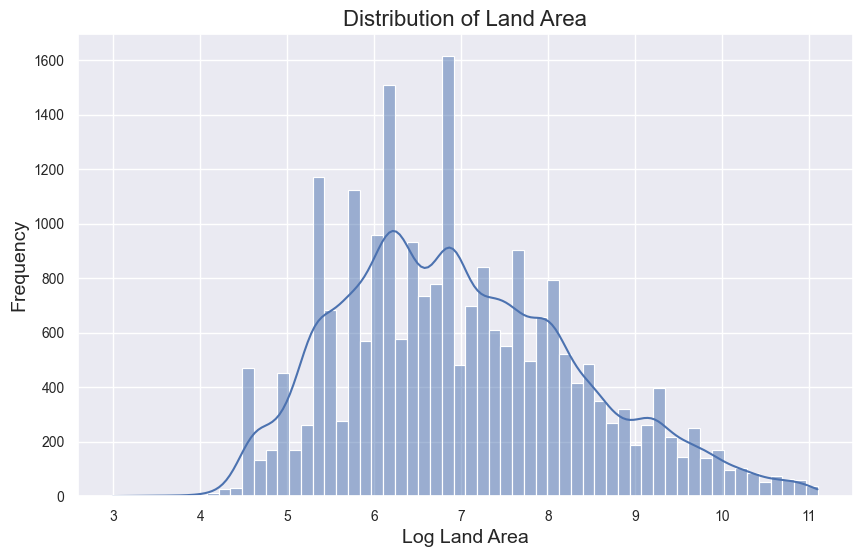

In [196]:
plt.figure(figsize=(10, 6))
sns.histplot(df['log_land_area'], kde=True)
plt.title('Distribution of Land Area')
plt.xlabel('Log Land Area')
plt.ylabel('Frequency')
plt.show()

### Price Total Distribution

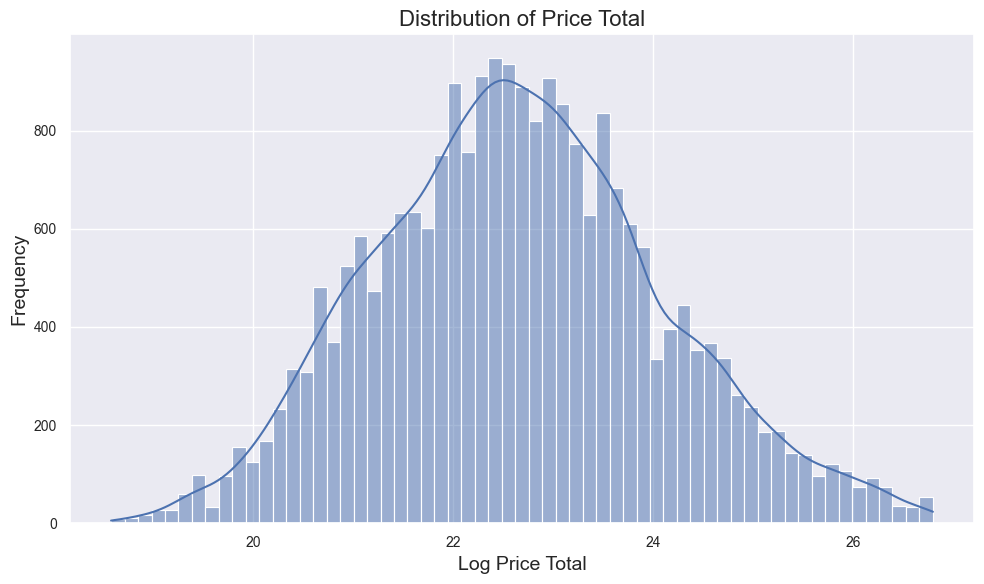

In [197]:
plt.figure(figsize=(10, 6))
sns.histplot(df['log_price_total'], kde=True)
plt.title('Distribution of Price Total')
plt.xlabel('Log Price Total')
plt.ylabel('Frequency')
# plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Price per m2 Distribution

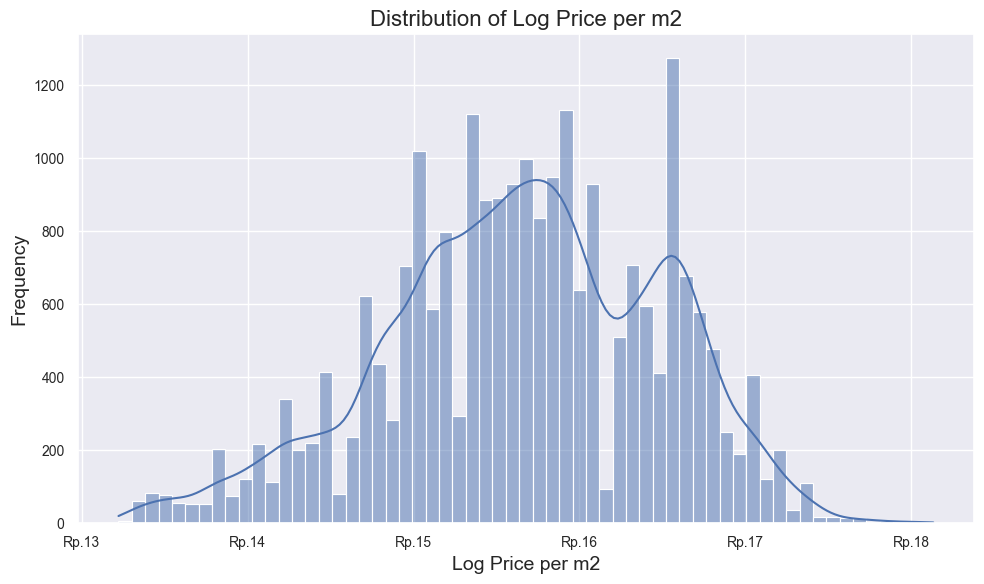

In [198]:
plt.figure(figsize=(10, 6))
sns.histplot(df['log_price_per_m2'], kde=True)
plt.title('Distribution of Log Price per m2')
plt.xlabel('Log Price per m2')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Regency Distribution

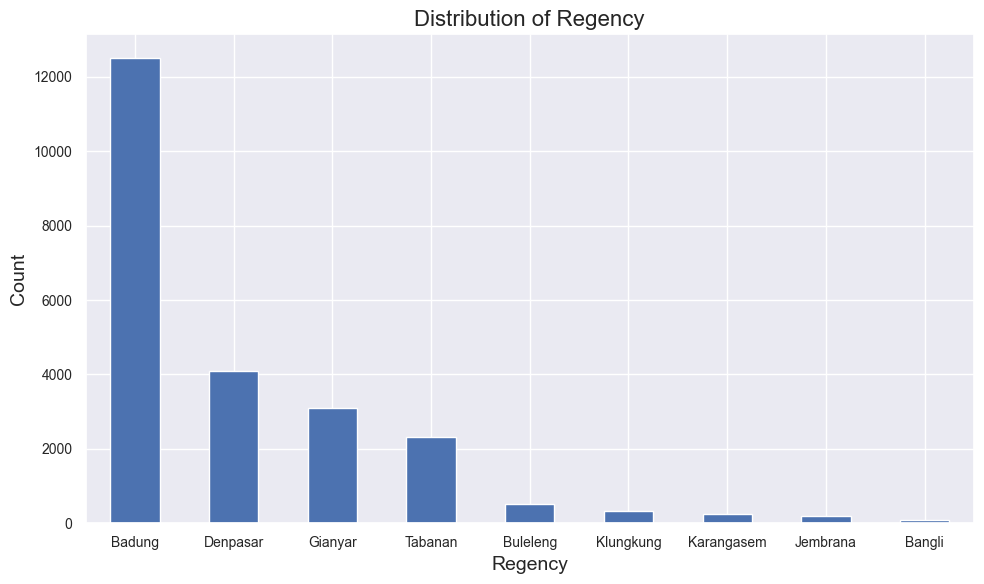

In [199]:
plt.figure(figsize=(10, 6))
df['regency'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Distribution of Regency')
plt.xlabel('Regency')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Land Area Category Distribution

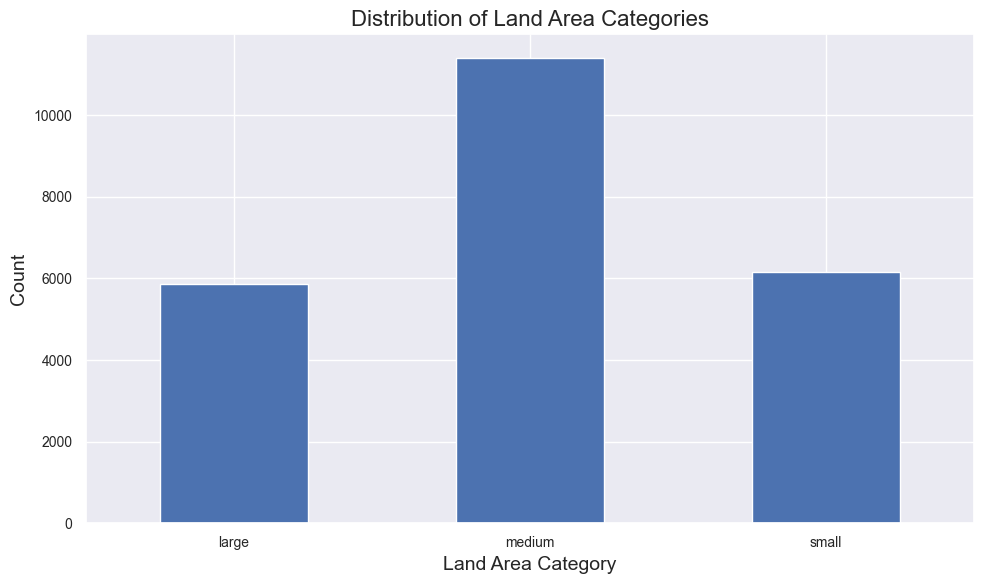

In [200]:
plt.figure(figsize=(10, 6))
df['land_area_cat'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Land Area Categories')
plt.xlabel('Land Area Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [201]:
df['land_area_cat'].value_counts().to_frame().T

land_area_cat,medium,small,large
count,11409,6156,5853


### Showing Price Total Over Time

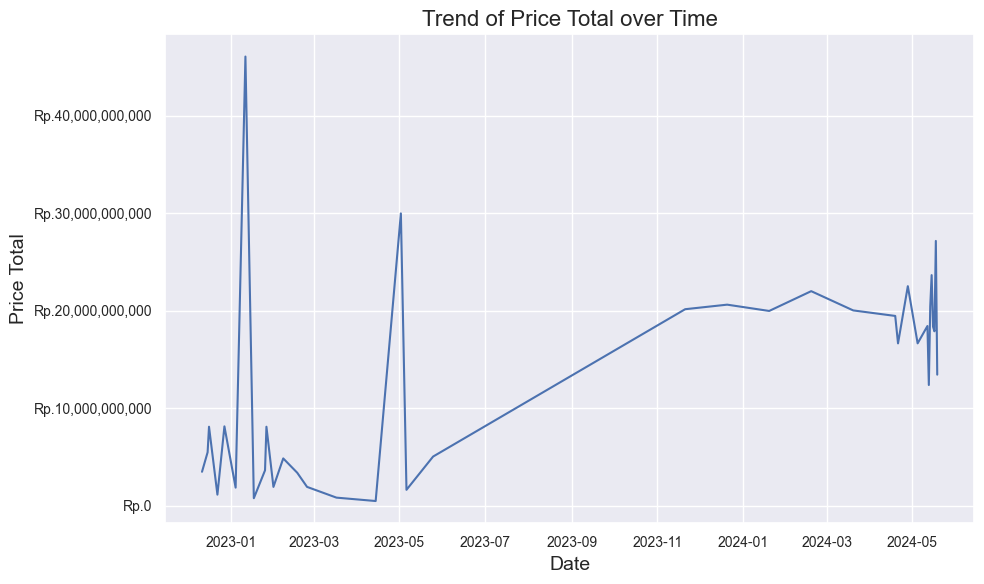

In [202]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='price_total', data=df, errorbar=None)
plt.title('Trend of Price Total over Time')
plt.xlabel('Date')
plt.ylabel('Price Total')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

In [203]:
price_per_m2_mean_overtime = df.groupby('date')['price_per_m2'].mean().reset_index()
price_per_m2_mean_overtime

,date,price_per_m2
0,2022-12-11,7.000000e+06
1,2022-12-15,2.500000e+06
2,2022-12-16,8.493724e+06
3,2022-12-22,1.100000e+07
4,2022-12-27,3.250000e+06
5,2023-01-04,5.000000e+06
6,2023-01-11,3.750000e+06
7,2023-01-17,4.500000e+06
8,2023-01-25,3.650000e+06
9,2023-01-26,8.493724e+06


### Showing Mean of Price per m2 Over Time

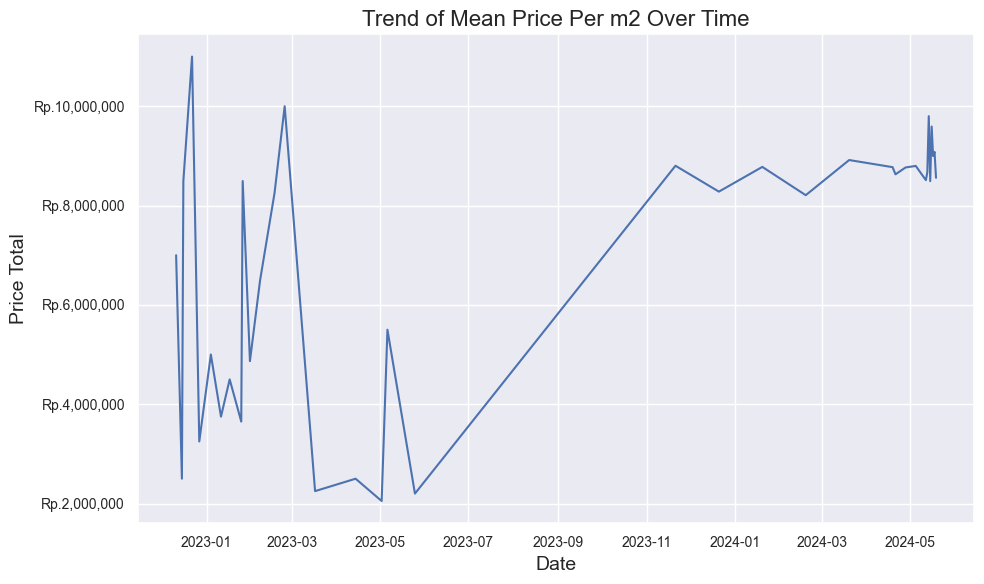

In [204]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='price_per_m2', data=price_per_m2_mean_overtime, errorbar=None)
plt.title('Trend of Mean Price Per m2 Over Time')
plt.xlabel('Date')
plt.ylabel('Price Total')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Showing Relationship between Price Total and Regency  

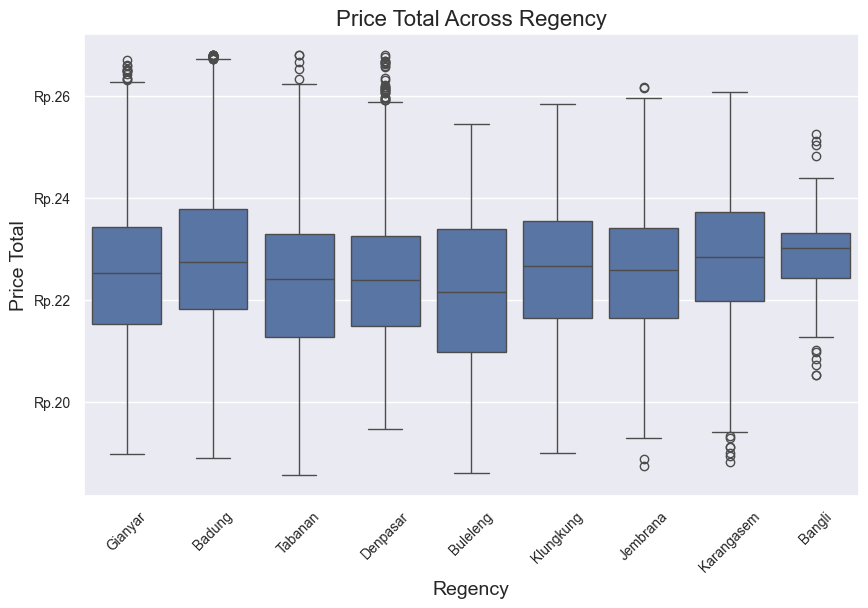

In [205]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='regency', y='log_price_total', data=df)
plt.title('Price Total Across Regency')
plt.xlabel('Regency')
plt.ylabel('Price Total')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [206]:
price_sum_by_regency = df.groupby('regency')['log_price_total'].sum()
price_sum_by_regency = price_sum_by_regency.sort_values(ascending=False)
price_sum_by_regency

regency
Badung        285966.031274
Denpasar       91621.689594
Gianyar        70135.336829
Tabanan        51730.982747
Buleleng       11482.337664
Klungkung       7449.509124
Karangasem      5824.502374
Jembrana        4137.716390
Bangli          2218.291233
Name: log_price_total, dtype: float64

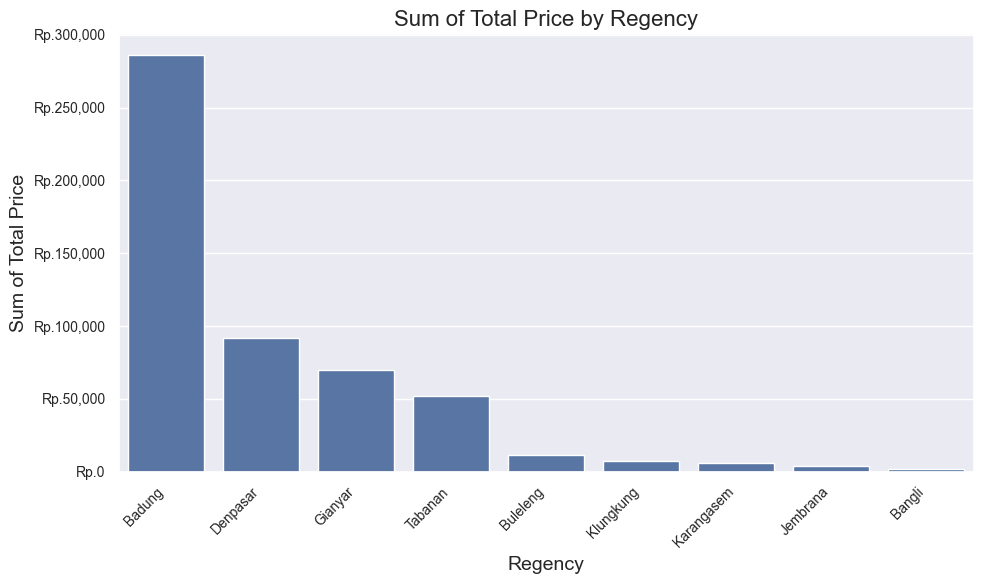

In [207]:
plt.figure(figsize=(10, 6))
sns.barplot(x=price_sum_by_regency.index, y=price_sum_by_regency.values)
plt.title('Sum of Total Price by Regency')
plt.xlabel('Regency')
plt.ylabel('Sum of Total Price')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

In [208]:
price_mean_by_regency = df.groupby('regency')['price_total'].mean()
price_mean_by_regency = price_mean_by_regency.sort_values(ascending=False)
price_mean_by_regency

regency
Badung        2.515814e+10
Karangasem    1.771496e+10
Gianyar       1.694846e+10
Jembrana      1.670698e+10
Klungkung     1.473155e+10
Denpasar      1.369854e+10
Bangli        1.345734e+10
Tabanan       1.327652e+10
Buleleng      1.025151e+10
Name: price_total, dtype: float64

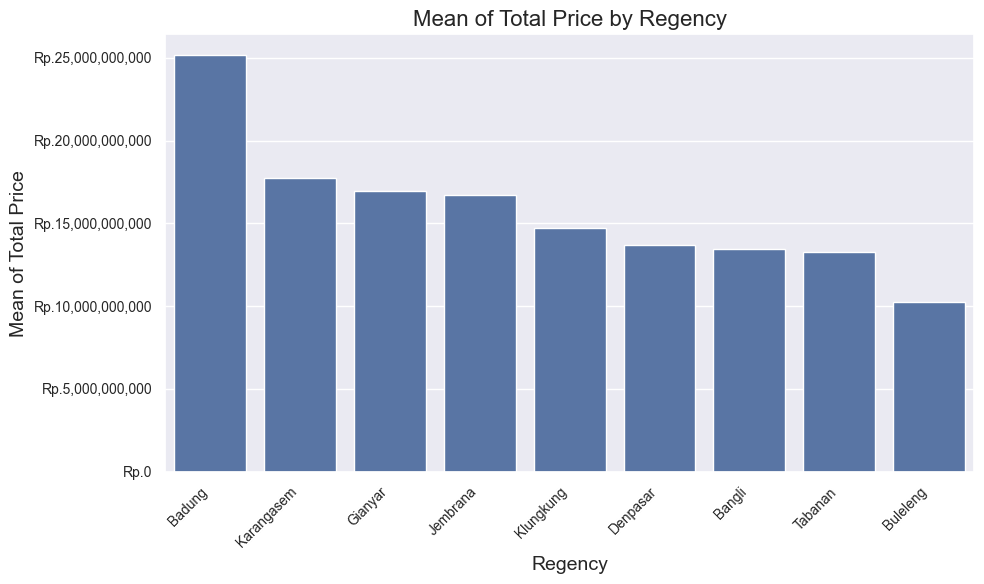

In [209]:
plt.figure(figsize=(10, 6))
sns.barplot(x=price_mean_by_regency.index, y=price_mean_by_regency.values)
plt.title('Mean of Total Price by Regency')
plt.xlabel('Regency')
plt.ylabel('Mean of Total Price')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Showing Relationship between Price per m2 and Regency  

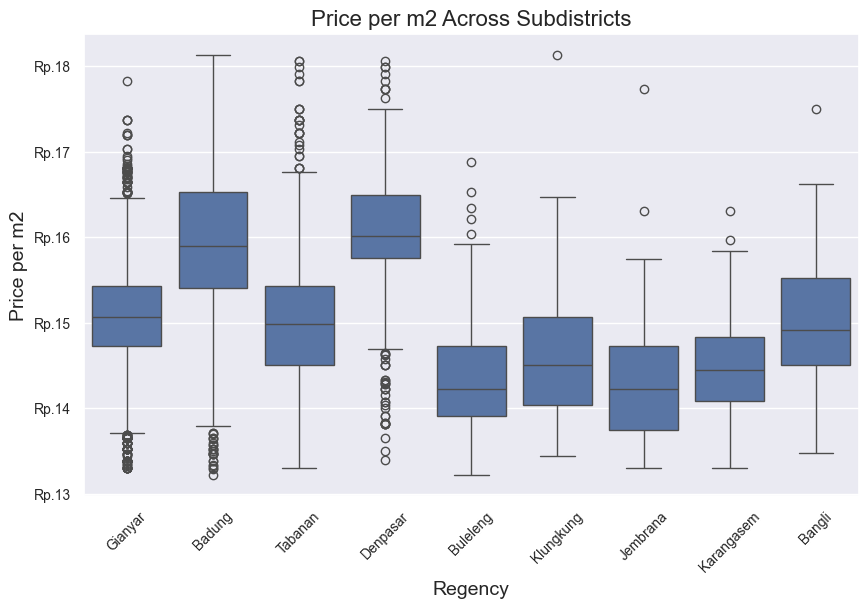

In [210]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='regency', y='log_price_per_m2', data=df)
plt.title('Price per m2 Across Subdistricts')
plt.xlabel('Regency')
plt.ylabel('Price per m2')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

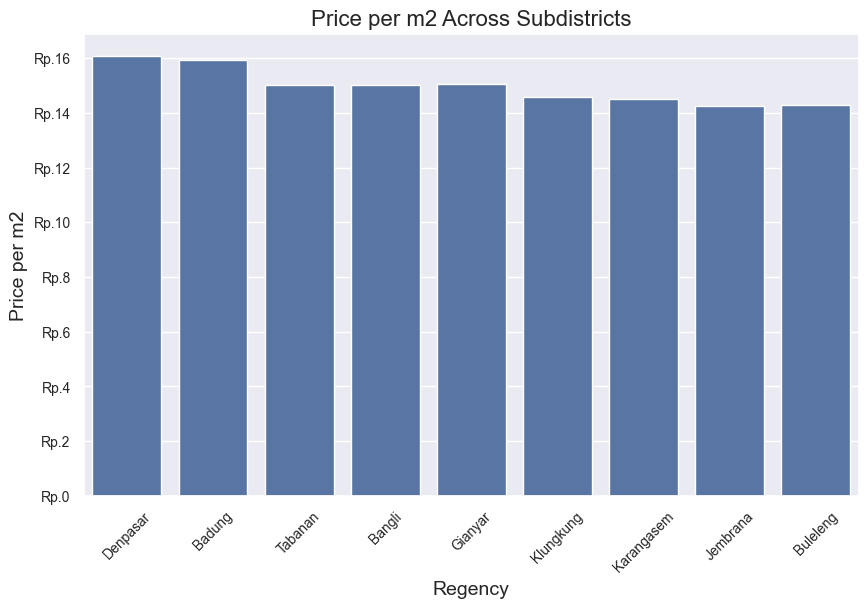

In [211]:
plt.figure(figsize=(10, 6))
sns.barplot(x='regency', y='log_price_per_m2', data=df, order=df.groupby('regency')['price_per_m2'].mean().sort_values(ascending=False).index, errorbar=None)
plt.title('Price per m2 Across Subdistricts')
plt.xlabel('Regency')
plt.ylabel('Price per m2')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [212]:
pricem2_sum_by_regency = df.groupby('regency')['price_per_m2'].sum()
pricem2_sum_by_regency = pricem2_sum_by_regency.sort_values(ascending=False)
pricem2_sum_by_regency

regency
Badung        1.300754e+11
Denpasar      4.528172e+10
Gianyar       1.314609e+10
Tabanan       1.025812e+10
Buleleng      1.031070e+09
Klungkung     9.353926e+08
Karangasem    5.892445e+08
Bangli        4.208718e+08
Jembrana      3.917970e+08
Name: price_per_m2, dtype: float64

In [213]:
pricem2_mean_by_regency = df.groupby('regency')['price_per_m2'].mean()
pricem2_mean_by_regency = pricem2_mean_by_regency.sort_values(ascending=False)
pricem2_mean_by_regency

regency
Denpasar      1.109302e+07
Badung        1.039190e+07
Tabanan       4.421601e+06
Bangli        4.338885e+06
Gianyar       4.224321e+06
Klungkung     2.834523e+06
Karangasem    2.301736e+06
Jembrana      2.129332e+06
Buleleng      1.982828e+06
Name: price_per_m2, dtype: float64

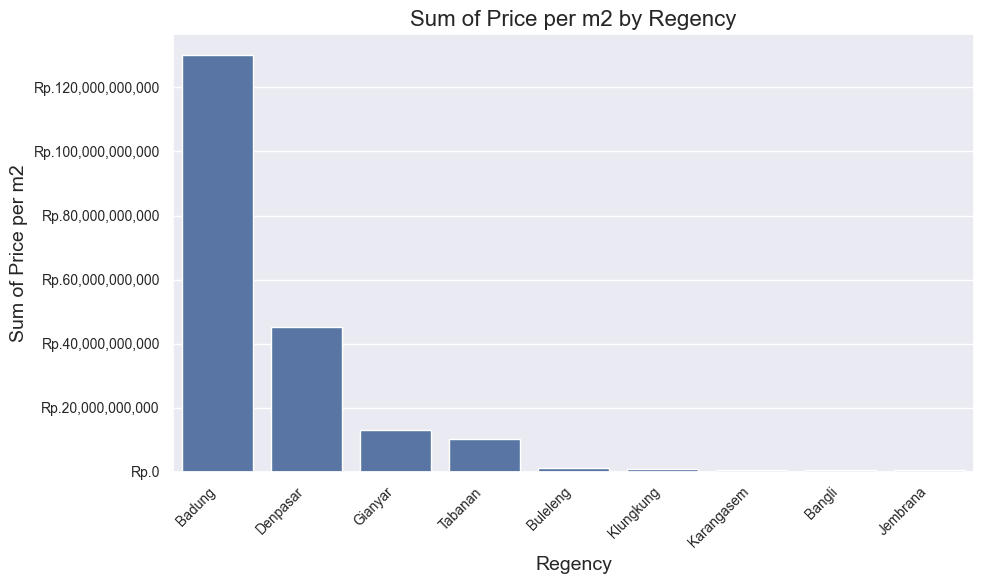

In [214]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pricem2_sum_by_regency.index, y=pricem2_sum_by_regency.values)
plt.title('Sum of Price per m2 by Regency')
plt.xlabel('Regency')
plt.ylabel('Sum of Price per m2')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

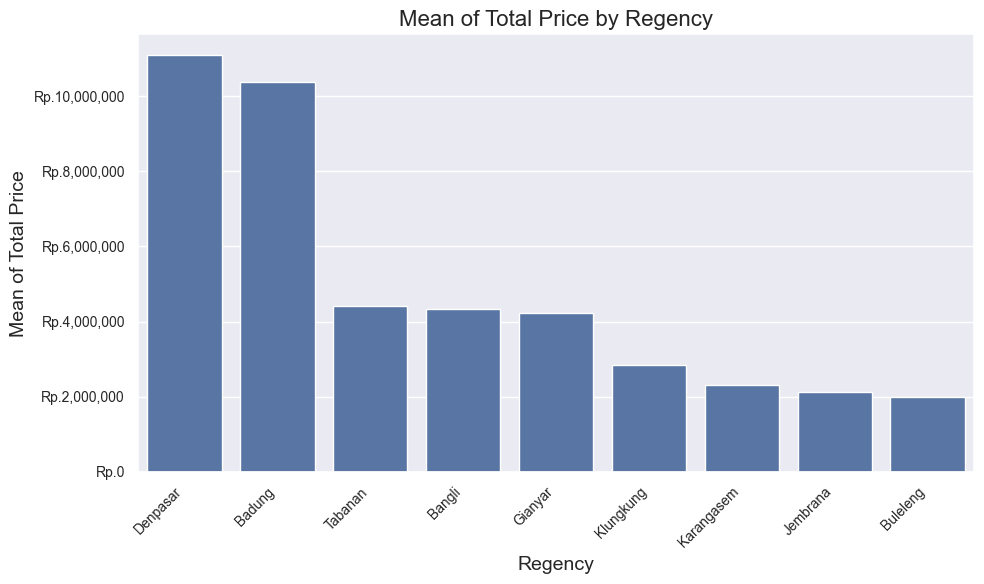

In [215]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pricem2_mean_by_regency.index, y=pricem2_mean_by_regency.values)
plt.title('Mean of Total Price by Regency')
plt.xlabel('Regency')
plt.ylabel('Mean of Total Price')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Showing Relationship between Land Area and Price Total

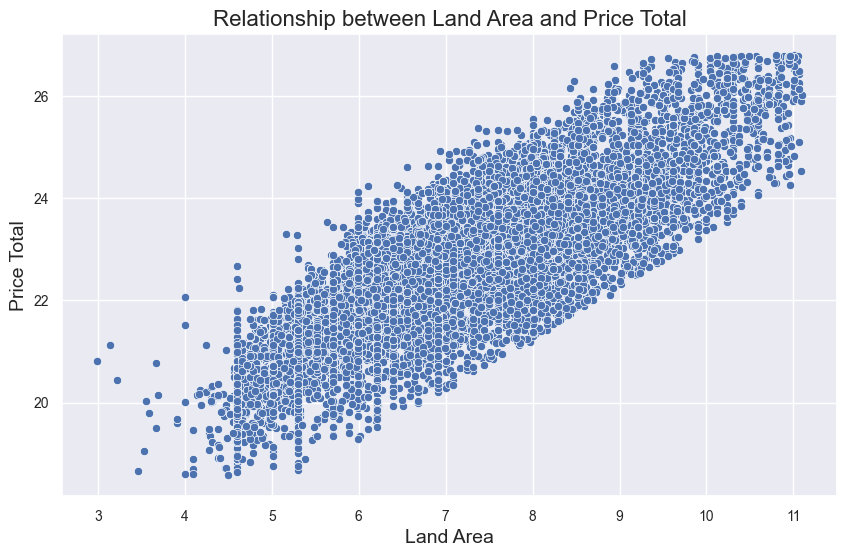

In [216]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_land_area', y='log_price_total', data=df)
plt.title('Relationship between Land Area and Price Total')
plt.xlabel('Land Area')
plt.ylabel('Price Total')
plt.show()

### Correlation Analysis

- Sort Regency Column by Price Per m2

In [217]:
price_sum_by_regency = df.groupby('regency')['log_price_per_m2'].sum()
price_sum_by_regency.sort_values(ascending=False)

regency
Badung        199325.339248
Denpasar       65662.287198
Gianyar        46859.364558
Tabanan        34819.002864
Buleleng        7436.109720
Klungkung       4806.913886
Karangasem      3709.967537
Jembrana        2621.941387
Bangli          1455.208115
Name: log_price_per_m2, dtype: float64

- Label Encoding on Regency Column

In [218]:
sorted_regencies = price_sum_by_regency.sort_values(ascending=True).index
encoding_dict = {regency: rank for rank, regency in enumerate(sorted_regencies, start=1)}

In [219]:
df['regency_encoded'] = df['regency'].map(encoding_dict)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded
0,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small,7
1,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small,9
2,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small,9
3,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small,9
4,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium,9


- Sort Subdistrict Column by Sum of Price Per m2

In [220]:
price_sum_by_subd = df.groupby('subdistrict')['log_price_per_m2'].sum()
price_sum_by_subd.sort_values(ascending=False)

subdistrict
Kuta Selatan        96951.937345
Kuta Utara          51162.757866
Denpasar Selatan    34658.245396
Kuta                26822.540867
Mengwi              21722.112416
Ubud                21240.772038
Kediri              18122.087827
Denpasar Barat      14872.034588
Denpasar Utara       8661.822379
Kerambitan           8058.484284
Sukawati             7970.802255
Denpasar Timur       7470.184835
Blahbatuh            6125.332319
Gianyar              5109.897867
Nusa Penida          3601.752513
Selemadeg            3535.752386
Tegallalang          2996.637655
Buleleng             2838.005921
Abiansemal           2222.591072
Payangan             1966.510741
Tabanan              1949.795805
Tampaksiring         1449.411684
Kintamani            1425.967656
Pekutatan            1338.667372
Selemadeg Timur      1026.636039
Karangasem           1026.281197
Banjar                960.081933
Sukasada              951.718742
Penebel               935.671499
Manggis               924.16249

- Label Encoding on Subdistrict Column

In [221]:
sorted_subdistrict = price_sum_by_subd.sort_values(ascending=True).index
encoding_subdistrict = {regency: rank for rank, regency in enumerate(sorted_subdistrict, start=1)}

In [222]:
df['subdistrict_encoded'] = df['subdistrict'].map(encoding_subdistrict)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded,subdistrict_encoded
0,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small,7,49
1,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small,9,54
2,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small,9,54
3,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small,9,51
4,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium,9,51


- Sort Land Area Category by Sum of Price Per m2

In [223]:
price_sum_by_landcat = df.groupby('land_area_cat')['log_price_per_m2'].sum()
price_sum_by_landcat.sort_values(ascending=False)

land_area_cat
medium    180321.149318
small      96811.891969
large      89563.093227
Name: log_price_per_m2, dtype: float64

- Label Encoding on Land Area Category Column

In [224]:
sorted_land_area = price_sum_by_landcat.sort_values(ascending=True).index
encoding_land_area = {landcat: rank for rank, landcat in enumerate(sorted_land_area, start=1)}

In [225]:
df['land_area_cat_encoded'] = df['land_area_cat'].map(encoding_land_area)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded,subdistrict_encoded,land_area_cat_encoded
0,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small,7,49,2
1,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small,9,54,2
2,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small,9,54,2
3,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small,9,51,2
4,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium,9,51,3


- Backup Dataframe

In [226]:
df_encoded = df.copy()
df_encoded.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded,subdistrict_encoded,land_area_cat_encoded
0,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small,7,49,2
1,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small,9,54,2
2,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small,9,54,2
3,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small,9,51,2
4,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium,9,51,3


- Delete the Categorical Column

In [227]:
df = df_encoded.copy()

df = df.drop(columns=['regency', 'subdistrict', 'land_area_cat'])
df.head()

,date,land_area,price_total,price_per_m2,log_land_area,log_price_total,log_price_per_m2,regency_encoded,subdistrict_encoded,land_area_cat_encoded
0,2024-05-19,200.0,7.000000e+08,3500000.0,5.298317,20.366591,15.068274,7,49,2
1,2024-05-19,200.0,8.000000e+08,4000000.0,5.298317,20.500122,15.201805,9,54,2
2,2024-05-19,376.0,3.572000e+09,9500000.0,5.929589,21.996391,16.066802,9,54,2
3,2024-05-19,100.0,1.500000e+09,15000000.0,4.605170,21.128731,16.523561,9,51,2
4,2024-05-19,2400.0,6.000000e+10,25000000.0,7.783224,24.817610,17.034386,9,51,3


- Correlation Matrix of Dataframe

In [228]:
if 'date' in df.columns:
    # Ensure the Date column is of datetime type
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    # Extract year, month, and day from the Date column
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    # Drop the Date column as it's now redundant
    df.drop('date', axis=1, inplace=True)

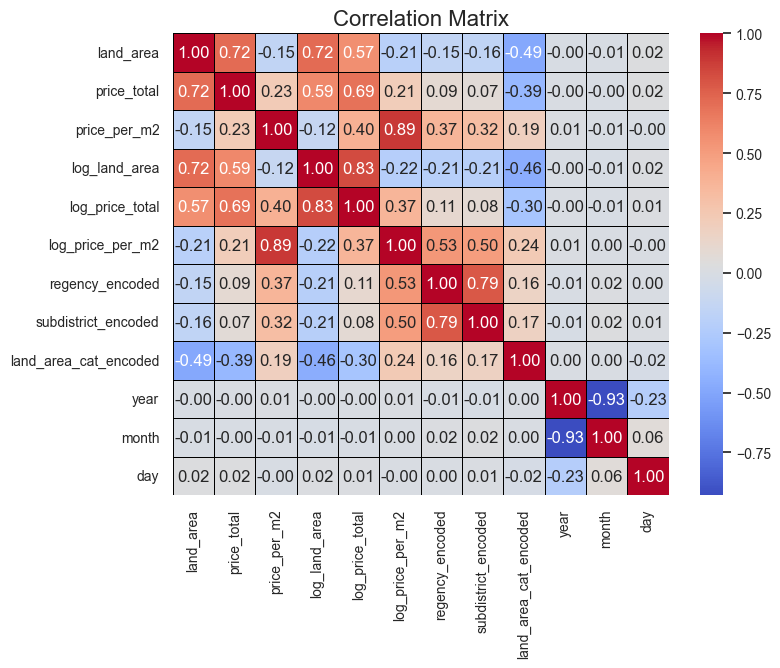

In [229]:
correlation_mat = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_mat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title("Correlation Matrix")
plt.show()

In [230]:
target_corr = correlation_mat['log_price_per_m2'].drop('log_price_per_m2')
print("Correlation with 'Price per m2':")
print(target_corr)

Correlation with 'Price per m2':
land_area               -0.205556
price_total              0.208739
price_per_m2             0.886987
log_land_area           -0.216474
log_price_total          0.367203
regency_encoded          0.526851
subdistrict_encoded      0.498167
land_area_cat_encoded    0.235486
year                     0.005897
month                    0.003381
day                     -0.001867
Name: log_price_per_m2, dtype: float64


In [231]:
correlation_threshold = 0.3
selected_features = target_corr[target_corr.abs() > correlation_threshold].index.tolist()

print("Selected features based on correlation:")
print(selected_features)

Selected features based on correlation:
['price_per_m2', 'log_price_total', 'regency_encoded', 'subdistrict_encoded']


# Model Building

### Select Features

In [232]:
# Model Features
features = ['month', 'day', 'regency_encoded', 'subdistrict_encoded']

# Model Target for Prediction
target = 'log_price_per_m2'

X = df[features]
y = df[target]

### Split Dataset

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### XGBoost Model

- Training Model

In [234]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, 
                        learning_rate=0.05, max_depth=6, colsample_bytree=0.7)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

- Evaluation Model

In [235]:
# Making predictions
xgb_predictions = xgb_model.predict(X_test)

# Evaluating the model
mse_xgb = mean_squared_error(y_test, xgb_predictions)
print(f"MSE of XGBoost model  : {mse_xgb:.3f}")

rmse_xgb = sqrt(mse_xgb)
print(f"RMSE of XGBoost model : {rmse_xgb:.3f}")

r2_xgb = r2_score(y_test, xgb_predictions)
print(f'R-squared: {r2_xgb:.3f}')

MSE of XGBoost model  : 0.340
RMSE of XGBoost model : 0.583
R-squared: 0.502


### Random Forest Model

- Training Model

In [236]:
rfr_model = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
 
rfr_model.fit(X, y)

RandomForestRegressor(oob_score=True, random_state=0)

- Evaluation Model

In [237]:
# Making predictions
rfr_predictions = rfr_model.predict(X)
 
# Evaluating the model
oob_score = rfr_model.oob_score_
print(f'Out-of-Bag Score: {oob_score:.3f}')

mse_rfr = mean_squared_error(y, rfr_predictions)
print(f'MSE of Random Forest Model  : {mse_rfr:.3f}')

rmse_rfr = sqrt(mse_rfr)
print(f"RMSE of Random Forest Model : {rmse_rfr:.3f}")

r2_rfr = r2_score(y, rfr_predictions)
print(f'R-squared: {r2_rfr:.3f}')

Out-of-Bag Score: 0.523
MSE of Random Forest Model  : 0.308
RMSE of Random Forest Model : 0.555
R-squared: 0.548


### Multiple Linear Regression

- Model Training

In [238]:
mlr_model = LinearRegression() 

mlr_model.fit(X_train, y_train)

LinearRegression()

- Evaluation Model

In [239]:
# Making predictions
mlr_predictions = mlr_model.predict(X_test)
 
# Evaluating the model
mse_mlr = mean_squared_error(y_test, mlr_predictions)
print(f'Mean Squared Error: {mse_mlr:.3f}')
 
rmse_mlr = sqrt(mse_mlr)
print(f"RMSE of the base model: {rmse_mlr:.3f}")

r2_mlr = r2_score(y_test, mlr_predictions)
print(f'R-squared: {r2_mlr:.3f}')

Mean Squared Error: 0.489
RMSE of the base model: 0.699
R-squared: 0.284


## Model Comparison

In [240]:
models = ['XGBoost', 'Random Forest', 'Multiple Linear Regression']

rmse_chart = [rmse_xgb, rmse_rfr, rmse_mlr]  
mse_chart = [mse_xgb, mse_rfr, mse_mlr]  
r2_chart = [r2_xgb, r2_rfr, r2_mlr]

- Bar Chart

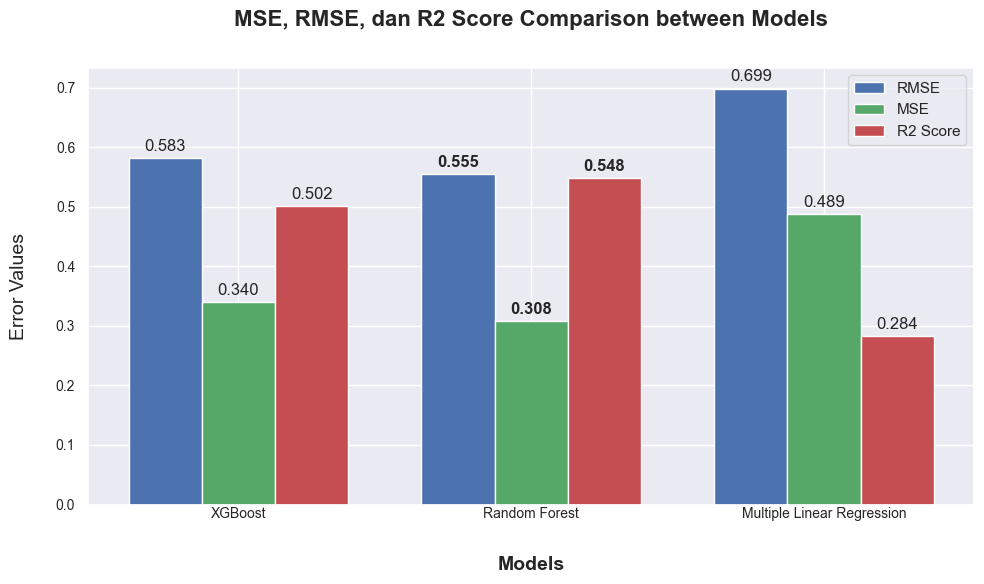

In [241]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25

index = np.arange(len(models))

# RMSE bars
rmse_bars = ax.bar(index, rmse_chart, bar_width, label='RMSE', color='b')

# MSE bars
mse_bars = ax.bar(index + bar_width, mse_chart, bar_width, label='MSE', color='g')

# r2 bars
r2_bars = ax.bar(index + bar_width + bar_width, r2_chart, bar_width, label='R2 Score', color='r')

# Labels, Title, and Legend
ax.set_xlabel('Models', fontweight='bold', labelpad=25)
ax.set_ylabel('Error Values', labelpad=20)
ax.set_title('MSE, RMSE, dan R2 Score Comparison between Models', fontweight='bold', pad=30)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(models)
ax.tick_params(axis='x', pad=-4)
ax.legend()


for bar in rmse_bars:
    height = bar.get_height()
    fontweight = 'normal'
    if height == min(rmse_chart):
        fontweight = 'bold'
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom', fontweight=fontweight)

for bar in mse_bars:
    height = bar.get_height()
    fontweight = 'normal' 
    if height == min(mse_chart):
        fontweight = 'bold'
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom', fontweight=fontweight)

for bar in r2_bars:
    height = bar.get_height()
    fontweight = 'normal' 
    if height == max(r2_chart):
        fontweight = 'bold'
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom', fontweight=fontweight)

# Plotting
plt.tight_layout()
plt.show()

### Export Models and Encoders

In [242]:
joblib.dump(rfr_model, '../models/rfr_model.pkl')
joblib.dump(xgb_model, '../models/xgboost_model.pkl')
joblib.dump(encoding_subdistrict, '../models/subdistrict_encode.pkl')
joblib.dump(encoding_dict, '../models/regency_encode.pkl')
joblib.dump(mlr_model, '../models/mlr_model.pkl')

['../models/mlr_model.pkl']

### Predicting Land Prices

In [159]:
subdistrict_label_encoder = joblib.load('../models/subdistrict_encode.pkl')
regency_label_encoder = joblib.load('../models/regency_encode.pkl')

# Function to get user input
def get_new_input():
    day = float(input("Enter the day: "))
    month = float(input("Enter the month: "))
    regency = input("Enter the regency: ")
    subdistrict = input("Enter the subdistrict: ")
    
    new_data = {
        'month': [month],
        'day': [day],
        'subdistrict': [subdistrict],
        'regency': [regency]
    }
    return pd.DataFrame(new_data)

# Get new data from user input
new_df = get_new_input()

# Encoding categorical features for new data
new_df['regency_encoded'] = new_df['regency'].map(regency_label_encoder)
new_df['subdistrict_encoded'] = new_df['subdistrict'].map(subdistrict_label_encoder)

# Drop non-numeric columns
new_df.drop(['subdistrict', 'regency'], axis=1, inplace=True)

- XGBoost Model Prediction

In [160]:
# Load the XGBoost Model
xgb_model_pred = joblib.load('../models/xgboost_model.pkl')

# Make predictions
new_predictions = xgb_model_pred.predict(new_df)
xgb_pred = np.exp(new_predictions[0])

In [161]:
# Print the predictions
print("Predicted price per m2: Rp{:,.2f}".format(xgb_pred))

Predicted price per m2: Rp1,752,213.62


- Random Forest Model Prediction

In [162]:
# Load the model
rfr_model_pred = joblib.load('../models/rfr_model.pkl')

# Make predictions
rfr_pred = rfr_model_pred.predict(new_df)
rfr_pred = np.exp(rfr_pred[0])

In [163]:
# Print the predictions
print("Predicted price per m2: Rp{:,.2f}".format(rfr_pred))

Predicted price per m2: Rp2,045,884.05


- Multiple Linear Regression

In [164]:
# Load the model
mlr_model_pred = joblib.load('../models/mlr_model.pkl')

# Make predictions
mlr_pred = mlr_model_pred.predict(new_df)
mlr_pred = np.exp(mlr_pred[0])

In [165]:
# Print the predictions
print("Predicted price per m2: Rp{:,.2f}".format(mlr_pred))

Predicted price per m2: Rp526,100.65


### Price Comparison

In [166]:
models = ['XGBoost', 'Random Forest', 'Multiple Linear Regression']
price_chart = [xgb_pred, rfr_pred, mlr_pred]

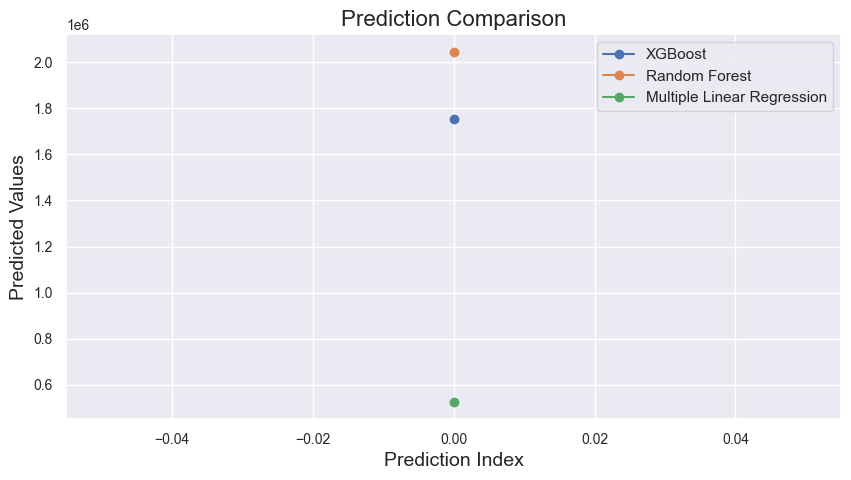

In [167]:
# Assuming each 'xgb_pred', 'rfr_pred', and 'mlr_pred' is a list of predictions
# Create a line chart with a separate line for each model
plt.figure(figsize=(10, 5))

for i, model_predictions in enumerate(price_chart):
    plt.plot(model_predictions, label=models[i], marker='o')  # Add a label for the legend

# Add title and labels
plt.title('Prediction Comparison')
plt.xlabel('Prediction Index')
plt.ylabel('Predicted Values')

# Add a legend to distinguish the lines
plt.legend()

# Show the plot
plt.show()

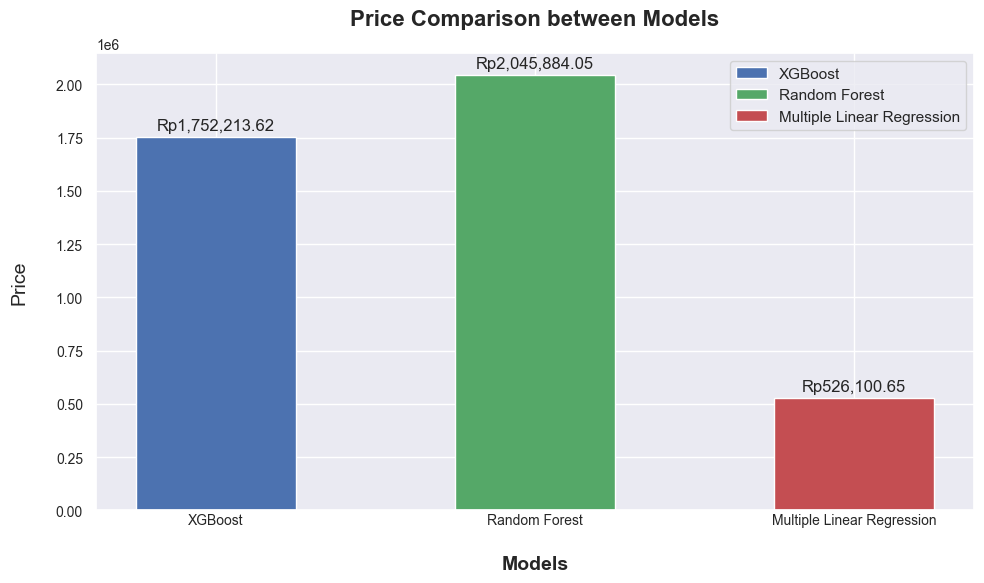

In [168]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set the bar width
bar_width = 0.2  # Keep the bars slim

# Set the positions of the bars on the x-axis closer together
index = np.arange(len(models)) * (bar_width + 0.2)

# Plot Price bars
# price_bars = ax.bar(index, price_chart, bar_width, label='Price', color='b')

# Define a list of colors for the bars
colors = ['b', 'g', 'r']

# Plot Price bars with different colors
for i in range(len(models)):
    ax.bar(index[i], price_chart[i], bar_width, label=models[i], color=colors[i])

# Add labels, title, and legend
ax.set_xlabel('Models', fontweight='bold', labelpad=20)
ax.set_ylabel('Price', labelpad=20)
ax.set_title('Price Comparison between Models', fontweight='bold', pad=20)
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.tick_params(axis='x', pad=-4)
ax.legend()

for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    fontweight = 'normal'
    ax.annotate(f'Rp{height:,.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight=fontweight)

# Show plot
plt.tight_layout()
plt.show()